<div class='alert alert-info'>
<h2>Working with ChemBL data web api</h2>
</div>

---
ChEMBL Data Web Services Documentation is [here](https://chembl.gitbook.io/chembl-interface-documentation/web-services/chembl-data-web-services) and REST Api documentation is [here](https://www.ebi.ac.uk/chembl/api/data/docs). We will also be using the ChEMBL webresource client [GitHub page](https://github.com/chembl/chembl_webresource_client) in this notebook. This is the official Python client library of ChEMBL group.

In this notebook we will take the help of LUX widget ([GitHub page](https://github.com/lux-org/lux)) to generate suggestion for data visualization.
***    

<a name='toc'></a>
### Table of Contents

1. [Imports](#imports)
2. [Fetch data](#fetch_data)
3. [Save data](#save_data)
4. [Read data](#read_data)
5. [Exploratroy data analysis](#explore)
6. [PAINS structural alerts](#pains)
   - 6.1. [Save PAINS data](#save_pains)
   - 6.2. [Load PAINS data](#load_pains)
   
7. [PAINS Compounds](#pains_compound)
8. [Parse ChemBL activity](#activity)
9. [Read PAINS activity data](#read_activity_pains)
10. [Activity data for a Target](#herg)
11. [R group decomposition/ SAR matrix](#rgd)

---

## To Do
- Generate representative small dataset
- write method to fetch activiy data for a give target. 
- SAR (R group decomposition)

<a name='imports'></a>
### Imports

In [1]:
# imports
import requests
#import lux
import json
import pprint
import pandas as pd
import urllib3
import certifi
from urllib3 import request
from chembl_webresource_client.new_client import new_client # ChemBL python api
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdDepictor
import rdkit
from rdkit.Chem import PandasTools
from rdkit import RDConfig
print(rdkit.__version__)
#print(time.ctime())

2021.03.3


### Define API Endpoints

In [9]:
#url = "https://www.ebi.ac.uk/chembl/api/data/compound_structural_alert.json"
chembl_structural_alerts = 'https://www.ebi.ac.uk/chembl/api/data/compound_structural_alert.json?limit=10000&offset=1&_=1625851370881'
chembl_activity = 'https://www.ebi.ac.uk/chembl/api/data/activity.json?limit=1000&offset=1&_=18635916'
chembl_molecule = 'https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000'

<a name='fetch_data'></a>
### Fetch data
Using the pagination feature in ChEMBL web service (described [here](https://chembl.gitbook.io/chembl-interface-documentation/web-services/chembl-data-web-services#meta-data-and-pagination)) fetch all the compounds with structural alerts. 

<div class='alert alert-danger'>
<b>Please note that the following code block might take long time to finish execution, as it retrives all the compounds with one or more chemical alerts in them</b>
<br>    
</div>

For the purpose of exploring this note book, you might consider using a small subset of data provided inside `data` directory. Please continue from [Step 4](#read_data). 

In [15]:
starting_url = 'https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000'
response = http.request('GET', starting_url)
data = json.loads(response.data.decode('utf-8'))
df = pd.json_normalize(data, record_path=['molecules'])
url_df = pd.json_normalize(data)
base = 'https://www.ebi.ac.uk'

next_url_exist = url_df['page_meta.next'][0]
print("Starting URL", starting_url)

while(next_url_exist):
    
    next_url = base + str(next_url_exist)
    response = http.request('GET', next_url)
    data = json.loads(response.data.decode('utf-8'))
    df_next = pd.json_normalize(data, record_path=['molecules'])
    next_url_df = pd.json_normalize(data)
    next_url_exist = next_url_df['page_meta.next'][0]
    df = df.append(df_next)
    print("shape of new df: ", df.shape)
    print ("Will use this url next: ", next_url)

Starting URL https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000
shape of new df:  (2000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=1000
shape of new df:  (3000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=2000
shape of new df:  (4000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=3000
shape of new df:  (5000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=4000
shape of new df:  (6000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=5000
shape of new df:  (7000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=6000
shape of new df:  (8000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=7000


KeyboardInterrupt: 

In [16]:
df

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,molecule_structures.molfile,molecule_structures.standard_inchi,molecule_structures.standard_inchi_key,biotherapeutic.biocomponents,biotherapeutic.description,biotherapeutic.helm_notation,biotherapeutic.molecule_chembl_id,molecule_properties,molecule_structures,molecule_hierarchy
0,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 24 26 0 0 0 0...,InChI=1S/C17H12ClN3O3/c1-10-8-11(21-17(24)20-1...,OWRSAHYFSSNENM-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 25 27 0 0 0 0...,InChI=1S/C18H12N4O3/c1-11-8-14(22-18(25)21-16(...,ZJYUMURGSZQFMH-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 25 27 0 0 0 0...,InChI=1S/C18H16ClN3O3/c1-10-7-14(22-18(25)21-1...,YOMWDCALSDWFSV-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 23 25 0 0 0 0...,InChI=1S/C17H13N3O3/c1-11-2-4-12(5-3-11)16(22)...,PSOPUAQFGCRDIP-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 24 26 0 0 0 0...,InChI=1S/C17H12ClN3O3/c1-10-8-13(21-17(24)20-1...,KEZNSCMBVRNOHO-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 15 15 0 0 0 0...,"InChI=1S/C7H4Cl5NO2/c1-15-4-2(8)5(7(10,11)12)1...",TZPIODJYHBQERO-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 18 18 0 0 0 0...,InChI=1S/C10H10Cl5NO2/c1-4(2)18-7-5(11)8(10(13...,XPEBJEXTTZHTJH-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,[],-1.0,NaN,0,NaN,-1,[],False,NaN,-1,...,\n RDKit 2D\n\n 17 17 0 0 0 0...,"InChI=1S/C9H8Cl5NO2/c1-3-17-6-4(10)7(9(12,13)1...",REEVUCJIDPDRNB-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a name='save_data'></a>
### Save the dataset

In [ ]:
df.info()
df.to_csv('data/chembl_structural_alerts.csv', sep=',', header=1)

<a name='read_data'></a>
### Read the dataset

A small subset of the dataset is available in `data` directory. 

In [2]:
# read the data
#df = pd.read_csv('data/chembl_structural_alerts.csv')

##============================================================================================#
## Please remove the # from the following line if you would like to work with small dataset   #
##============================================================================================#
df = pd.read_csv('data/chembl_structural_alerts_small.csv')

In [3]:
## Display a snippet of dataframe
df

,Unnamed: 0,Unnamed: 0.1,cpd_str_alert_id,molecule_chembl_id,alert.alert_id,alert.alert_name,alert.alert_set.priority,alert.alert_set.set_name,alert.smarts
0,18006,6,49322628,CHEMBL336173,7,R7 Peroxides,8,Glaxo,OO
1,1220,220,49305842,CHEMBL304064,1,R1 Reactive alkyl halides,8,Glaxo,"[Br,Cl,I][CX4;CH,CH2]"
2,15186,186,49319808,CHEMBL4473013,2,R2 Acid halides,8,Glaxo,"[S,C](=[O,S])[F,Br,Cl,I]"
3,10234,234,49314856,CHEMBL2288057,1,R1 Reactive alkyl halides,8,Glaxo,"[Br,Cl,I][CX4;CH,CH2]"
4,16680,680,49321302,CHEMBL4168681,5,R5 Sulphonates,8,Glaxo,"COS(=O)(=O)[C,c]"
...,...,...,...,...,...,...,...,...,...
19704,7677,677,49312299,CHEMBL1796159,1,R1 Reactive alkyl halides,8,Glaxo,"[Br,Cl,I][CX4;CH,CH2]"
19705,7548,548,49312170,CHEMBL1765132,1,R1 Reactive alkyl halides,8,Glaxo,"[Br,Cl,I][CX4;CH,CH2]"
19706,11187,187,49315809,CHEMBL3219161,1,R1 Reactive alkyl halides,8,Glaxo,"[Br,Cl,I][CX4;CH,CH2]"
19707,15615,615,49320237,CHEMBL202076,5,R5 Sulphonates,8,Glaxo,"COS(=O)(=O)[C,c]"


***The LUX widget plot of alert set name Vs number of recored seems interesting let's export that and visualize here.*** 

<a name='explore'></a>
### Exploratory data analysis

***Questions:***

Let's count the number of unique values in each coloumn.  

In [4]:
df.nunique()

Unnamed: 0                  12427
Unnamed: 0.1                 1000
cpd_str_alert_id            12426
molecule_chembl_id          12363
alert.alert_id                  7
alert.alert_name                7
alert.alert_set.priority        1
alert.alert_set.set_name        1
alert.smarts                    7
dtype: int64

In [ ]:
df['alert.alert_set.set_name'].unique()

In [ ]:
df['alert.alert_set.set_name'].value_counts()

***There are 5 unique alert set, namely BMS, Dundee, Glaxo, MLSMR, and PAINS***. 
Largest alert set in terms of number of compounds is MLSMR and smallest is PAINS. 

Let's plot some charts. First a bar plot of alert names and thier occurence count.

In [ ]:
df['alert.alert_set.set_name'].value_counts().plot.bar(figsize=(15, 10))

Let's plot a pie chart

In [ ]:
df['alert.alert_set.set_name'].value_counts().plot.pie(figsize=(18, 14), legend=True)

In [ ]:
df['cpd_str_alert_id'].groupby(df['alert.alert_set.set_name']).describe()

<a name='pains'></a>
### PAINS alert set

Let's now focus on PAINS

In [ ]:
# select where the set_name is PAINS
df_pains = df[df["alert.alert_set.set_name"] == 'PAINS']
df_pains

<a name='save_pains'></a>
#### Save the PAINS dataset

In [ ]:
df_pains.to_csv('data/chembl_structural_alerts_pains.csv', sep=',', header=True)

<a name='load_pains'></a>
#### Load the PAINS dataset

In [2]:
df_pains = pd.read_csv('data/chembl_structural_alerts_pains.csv')
df_pains

,cpd_str_alert_id,molecule_chembl_id,alert.alert_id,alert.alert_name,alert.alert_set.priority,alert.alert_set.set_name,alert.smarts
0,51114487,CHEMBL6608,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
1,51114488,CHEMBL268413,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
2,51114489,CHEMBL417,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
3,51114490,CHEMBL216758,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
4,51114491,CHEMBL269021,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
...,...,...,...,...,...,...,...
63349,53246076,CHEMBL4646491,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
63350,53246129,CHEMBL4634850,345,quinone_A(370),6,PAINS,"[!#6&!#1]=[#6]1[#6]=,:[#6][#6](=[!#6&!#1])[#6]..."
63351,53246301,CHEMBL4646116,349,anil_di_alk_B(251),6,PAINS,c:1:c:c(:c:c:c:1-[#7](-[#6;X4])-[#6;X4])-[#6]=...
63352,53246403,CHEMBL4641916,349,anil_di_alk_B(251),6,PAINS,c:1:c:c(:c:c:c:1-[#7](-[#6;X4])-[#6;X4])-[#6]=...


In [3]:
df_pains['alert.alert_name'].value_counts()

quinone_A(370)          15799
azo_A(324)               8957
anil_di_alk_C(246)       6151
ene_rhod_A(235)          3846
amino_acridine_A(46)     3485
                        ...  
cyano_misc_A(1)             1
diazox_A(3)                 1
naphth_ene_one_C(1)         1
cyano_pyridone_F(3)         1
het_pyridiniums_C(1)        1
Name: alert.alert_name, Length: 84, dtype: int64

Let's plot the count of each alert name. 

#### All the columns

In [5]:
df_pains.columns

Index(['cpd_str_alert_id', 'molecule_chembl_id', 'alert.alert_id',
       'alert.alert_name', 'alert.alert_set.priority',
       'alert.alert_set.set_name', 'alert.smarts'],
      dtype='object')

<AxesSubplot:>

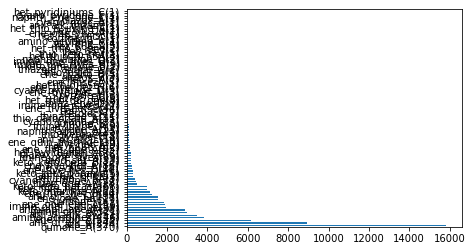

In [6]:
df_pains['alert.alert_name'].value_counts().plot(kind='barh')

Seems like the plot is quite crowded, let's plot only first 10 or 20 values. 

<AxesSubplot:>

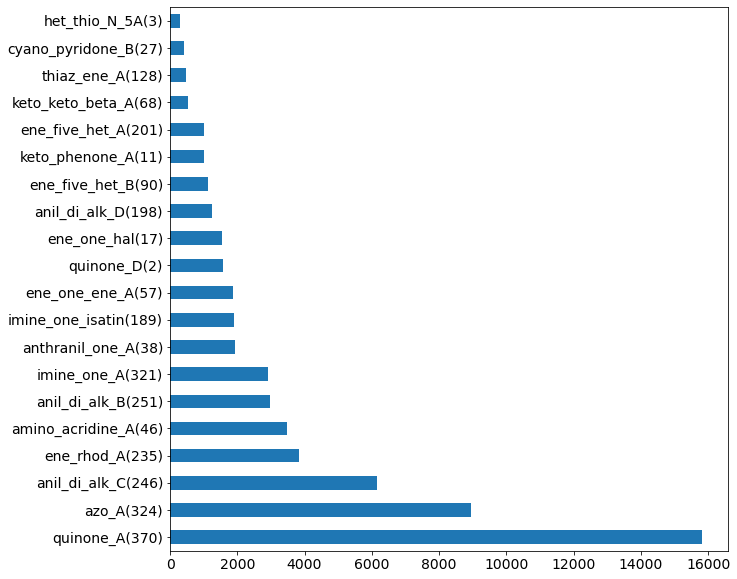

In [7]:
df_pains['alert.alert_name'].value_counts()[:20].plot(kind='barh', figsize=(10,10), fontsize=14)

<a name='pains_compound'></a>
### PAINS compound

Let's download and analyze all the compunds with PAINS. 

In [21]:
# import function to retreive data
from utils.utils import fetch_chembl_data
pains_compounds = fetch_chembl_data(chembl_molecule, data_file='pains_molecule.csv', record_path='molecules')

'data' directory already exist. Will use it to save output files.
data will be written into: data/pains_molecule.csv
Starting URL https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000
Last fetch took : 0:00:04.212676 seconds
shape of new df:  (2000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=1000
Last fetch took : 0:00:03.737342 seconds
shape of new df:  (3000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=2000
Last fetch took : 0:00:04.169970 seconds
shape of new df:  (4000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=3000
Last fetch took : 0:00:09.431418 seconds
shape of new df:  (5000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000&offset=4000
Last fetch took : 0:00:04.198807 seconds
shape of new df:  (6000, 70)
Will use this url next:  https://www.ebi.ac.uk/chembl/api

KeyboardInterrupt: 

<a name='activity'></a>
### Parse ChEMBL activity

In [ ]:
starting_activity_url = '/chembl/api/data/activity.json?limit=1000&offset=1&_=18635916'
#https://www.ebi.ac.uk/chembl/api/data/compound_structural_alert.json?limit=10000&offset=1&_=1625851370881
base = 'https://www.ebi.ac.uk'
starting_activity_url = base + starting_activity_url
starting_activity_url

In [2]:
#import function to retreive data
from utils.utils import fetch_chembl_data

<div class='alert alert-danger'>
<b>Please note that the following code block might take long time to finish execution, as it retrives all the activity data for a given list of compounds</b>
<hr>
You might use the sample data provided (data/activity_pains_sampel.csv) and continue with the next step
<br>    
</div>

In [5]:
# fetch_chembl_data fetched the data from ChemBL and writes it in csv format. It also returns the data as pandas dataframe. Please see more detail of this function by 
# running print(fetch_chembl_data.__doc__).
df_activity = fetch_chembl_data(starting_activity_url, data_file='data/activity_pains_test.csv',
                                compound_ids=df_pains['molecule_chembl_id'], method='GET', record_path='activities')

NameError: name 'starting_activity_url' is not defined

<a name='read_activity_pains'></a>
### Read activity data                                                                                                                      


[Go TOP](#toc)

In [5]:
df_activity_pains = pd.read_csv('data/activity_pains.csv')

/home/bnizami/miniconda2/envs/my-rdkit-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df_activity_pains[['activity_id', 'assay_chembl_id', 'molecule_chembl_id']]

,activity_id,assay_chembl_id,molecule_chembl_id
0,32061,CHEMBL706332,CHEMBL542565
1,32062,CHEMBL758597,CHEMBL542565
2,32063,CHEMBL762168,CHEMBL542565
3,32064,CHEMBL759554,CHEMBL542565
4,32065,CHEMBL706332,CHEMBL543512
...,...,...,...
6357844,623500,CHEMBL879519,CHEMBL64918
6357845,623501,CHEMBL710419,CHEMBL64918
6357846,623502,CHEMBL653576,CHEMBL64918
6357847,623503,CHEMBL653578,CHEMBL64918


In [5]:
df_activity_pains[df_activity_pains['molecule_chembl_id'].isin(df_pains['molecule_chembl_id'])]

,Unnamed: 0,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,type,units,uo_units,upper_value,value,ligand_efficiency.bei,ligand_efficiency.le,ligand_efficiency.lle,ligand_efficiency.sei,ligand_efficiency
0,197,NaN,32061,[],CHEMBL706332,Tested in vitro against murine L1210 leukemia.,F,NaN,NaN,BAO_0000190,...,IC50,M,UO_0000065,NaN,8.700000e-07,NaN,NaN,NaN,NaN,NaN
1,198,NaN,32062,[],CHEMBL758597,Optimal dose per injection in mg/kg required t...,F,NaN,NaN,BAO_0000179,...,Dose,mg kg-1,UO_0000308,NaN,6.250000e+00,NaN,NaN,NaN,NaN,NaN
2,199,NaN,32063,[],CHEMBL762168,"Activity against P388 leukemia cells in mice, ...",F,NaN,NaN,BAO_0000181,...,Activity,NaN,NaN,NaN,3.400000e+00,NaN,NaN,NaN,NaN,NaN
3,200,NaN,32064,[],CHEMBL759554,"Inhibition of P388 leukemia cells in mice, mea...",F,NaN,NaN,BAO_0001103,...,T/C,%,UO_0000187,NaN,1.940000e+02,NaN,NaN,NaN,NaN,NaN
4,201,NaN,32065,[],CHEMBL706332,Tested in vitro against murine L1210 leukemia.,F,NaN,NaN,BAO_0000190,...,IC50,M,UO_0000065,NaN,9.300000e-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6357844,889,NaN,623500,[],CHEMBL879519,Inhibitory activity against proliferation of M...,F,NaN,NaN,BAO_0080003,...,IC30,uM,UO_0000064,NaN,5.700000e+00,NaN,NaN,NaN,NaN,NaN
6357845,890,NaN,623501,[],CHEMBL710419,Percent of inhibitory activity against prolife...,F,NaN,NaN,BAO_0000201,...,Inhibition,%,UO_0000187,NaN,4.800000e+01,NaN,NaN,NaN,NaN,NaN
6357846,891,NaN,623502,[],CHEMBL653576,Inhibitory activity against proliferation of B...,F,NaN,NaN,BAO_0080003,...,IC30,uM,UO_0000064,NaN,1.000000e+01,NaN,NaN,NaN,NaN,NaN
6357847,892,NaN,623503,[],CHEMBL653578,Percent of inhibitory activity against prolife...,F,NaN,NaN,BAO_0000201,...,Inhibition,%,UO_0000187,NaN,3.000000e+01,NaN,NaN,NaN,NaN,NaN


### Types of activity

<AxesSubplot:ylabel='type'>

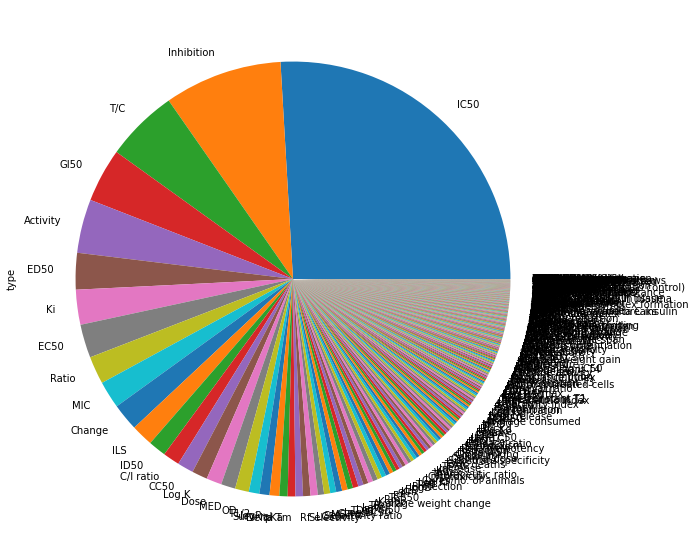

In [4]:
# plot type
df_activity_pains['type'].value_counts().plot(kind='pie', figsize=(10,10))

In [5]:
df_activity_pains['type'].value_counts()

IC50          1647544
Inhibition     557474
T/C            342686
GI50           254400
Activity       253774
               ...   
TOC ED50            4
IC30                2
RBA2                1
Agonism             1
RBA1                1
Name: type, Length: 451, dtype: int64

As we see there are more than 450 uniques values in `type` column, hence the pie chart get messy and not easy to read. We can try limiting the number of uniques values. 

<AxesSubplot:ylabel='type'>

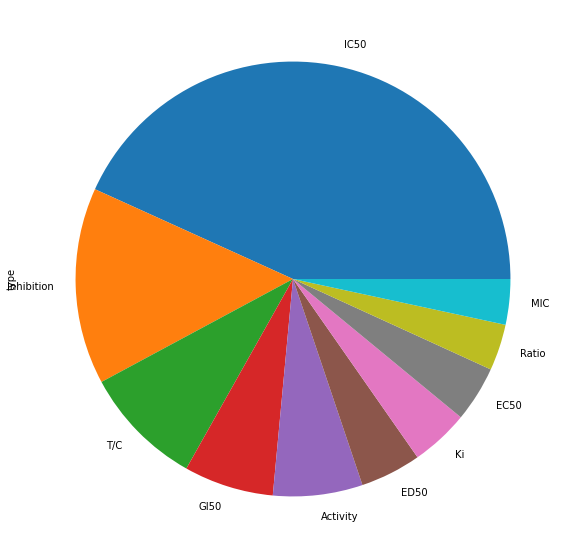

In [16]:
# plot first 10 value of 'type'
df_activity_pains['type'].value_counts()[:10].plot(kind='pie', figsize=(10,10))

***Let's see what other columns are there*** 

In [19]:
df_activity_pains.columns

Index(['Unnamed: 0', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'molecule_chembl_id', 'molecule_pref_name',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag',
       'standard_relation', 'standard_text_value', 'standard_type',
       'standard_units', 'standard_upper_value', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name',
       'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units',
       'upper_value', 'value', 'ligand_efficiency.bei', 'ligand_efficiency.le',
       'ligand_efficiency.lle', 'ligand_efficiency.sei

### Plot target organism

In [20]:
df_activity_pains['target_organism'].value_counts()

Homo sapiens                                               2099153
Mus musculus                                               1653785
Rattus norvegicus                                           493133
Bos taurus                                                  139755
Human immunodeficiency virus 1                               91992
                                                            ...   
Serratia marcescens                                            150
Mycobacterium intracellulare                                   142
Salmonella enterica subsp. enterica serovar Paratyphi A        132
Human herpesvirus 3                                             34
Human herpesvirus 4                                             34
Name: target_organism, Length: 131, dtype: int64

In [36]:
df_activity_pains['assay_description'].unique()

array(['Tested in vitro against murine L1210 leukemia.',
       'Optimal dose per injection in mg/kg required to inhibit growth of P388 leukemia cells in mice',
       'Activity against P388 leukemia cells in mice, by intraperitoneal dosing and net log tumor cell kill was reported',
       ...,
       'Inhibitory activity against proliferation of BT-20 cells in presence of TPE at 10e-5 M concentration.',
       'Percent of inhibitory activity against proliferation of BT-20 cells in presence of TPE at 10e-5 M concentration.',
       'Relative binding affinity for antiestrogen binding site (AEBS) of calf uterus 2 hr incubation at 0C'],
      dtype=object)

<a name='herg'></a>
### Fetch all the activity associated with a target

Let's focus on a specific target from the below list:

- hERG ChemBL target ID = CHEMBL240
- IRAK-4 = CHEMBL3778

In [2]:
from chembl_webresource_client.new_client import new_client

activity = new_client.activity
res = activity.filter(target_chembl_id='CHEMBL3778', assay_type='B')

len(res)

4617

In [3]:
type(res)

chembl_webresource_client.query_set.QuerySet

In [4]:
res

[{'activity_comment': None, 'activity_id': 578269, 'activity_properties': [], 'assay_chembl_id': 'CHEMBL698856', 'assay_description': 'Inhibition of Interleukin-1 receptor-associated kinase-4', 'assay_type': 'B', 'assay_variant_accession': None, 'assay_variant_mutation': None, 'bao_endpoint': 'BAO_0000190', 'bao_format': 'BAO_0000357', 'bao_label': 'single protein format', 'canonical_smiles': 'C[C@H](O)CNc1cc(-c2[nH]c3cccnc3c2-c2ccc(F)cc2)ccn1', 'data_validity_comment': None, 'data_validity_description': None, 'document_chembl_id': 'CHEMBL1145138', 'document_journal': 'J. Med. Chem.', 'document_year': 2003, 'ligand_efficiency': None, 'molecule_chembl_id': 'CHEMBL142425', 'molecule_pref_name': None, 'parent_molecule_chembl_id': 'CHEMBL142425', 'pchembl_value': None, 'potential_duplicate': False, 'qudt_units': 'http://www.openphacts.org/units/Nanomolar', 'record_id': 277081, 'relation': '>', 'src_id': 1, 'standard_flag': True, 'standard_relation': '>', 'standard_text_value': None, 'stand

In [5]:
df_activity_pains = pd.DataFrame(list(res))

In [6]:
df_activity_pains

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,578269,[],CHEMBL698856,Inhibition of Interleukin-1 receptor-associate...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,IC50,uM,UO_0000065,None,30.0
1,None,1663207,[],CHEMBL863888,Inhibitory activity against IRAK4,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,IC50,uM,UO_0000065,None,25.0
2,None,1723345,[],CHEMBL861307,Inhibition of IRAK4,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,Ki,nM,UO_0000065,None,9900.0
3,None,1723614,[],CHEMBL861307,Inhibition of IRAK4,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,Ki,nM,UO_0000065,None,9900.0
4,None,1723615,[],CHEMBL861307,Inhibition of IRAK4,B,None,None,BAO_0000192,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,Ki,nM,UO_0000065,None,9900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,Not Active,20780884,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,None,None,BAO_0000179,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,% Control,%,UO_0000187,None,100.0
4613,Not Active,20781352,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,None,None,BAO_0000179,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,% Control,%,UO_0000187,None,87.0
4614,Not Active,20781929,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,None,None,BAO_0000179,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,% Control,%,UO_0000187,None,100.0
4615,Slightly Active,20782398,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,None,None,BAO_0000179,BAO_0000357,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,None,None,% Control,%,UO_0000187,None,48.8


There are 50 coloumn in the above dataframe, let's choose only few relevant ones.  

### Save the activity data

In [7]:
df_activity_pains.to_csv('data/irak4_activity_data.csv', header=True, sep=',')

### Read activity data

In [71]:
df_activity_pains = pd.read_csv('data/irak4_activity_data.csv')

In [52]:
## All the columns
print(df_activity_pains.columns)

Index(['Unnamed: 0', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


In [72]:
col_to_choose = [ 'activity_id', 'ROMol',
       'assay_chembl_id', 'assay_description', 'assay_type', 'canonical_smiles', 'molecule_chembl_id', 'pchembl_value',
       'record_id', 'relation', 'standard_flag',
       'standard_relation', 'standard_text_value', 'standard_type',
       'standard_units', 'standard_upper_value', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name',
       'type', 'units', 'value']

In [73]:
df_activity_pains

,Unnamed: 0,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,0,NaN,578269,[],CHEMBL698856,Inhibition of Interleukin-1 receptor-associate...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,30.0
1,1,NaN,1663207,[],CHEMBL863888,Inhibitory activity against IRAK4,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,25.0
2,2,NaN,1723345,[],CHEMBL861307,Inhibition of IRAK4,B,NaN,NaN,BAO_0000192,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,9900.0
3,3,NaN,1723614,[],CHEMBL861307,Inhibition of IRAK4,B,NaN,NaN,BAO_0000192,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,9900.0
4,4,NaN,1723615,[],CHEMBL861307,Inhibition of IRAK4,B,NaN,NaN,BAO_0000192,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,Ki,nM,UO_0000065,NaN,9900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,4612,Not Active,20780884,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,NaN,NaN,BAO_0000179,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,% Control,%,UO_0000187,NaN,100.0
4613,4613,Not Active,20781352,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,NaN,NaN,BAO_0000179,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,% Control,%,UO_0000187,NaN,87.0
4614,4614,Not Active,20781929,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,NaN,NaN,BAO_0000179,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,% Control,%,UO_0000187,NaN,100.0
4615,4615,Slightly Active,20782398,"[{'comments': None, 'relation': None, 'result_...",CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,NaN,NaN,BAO_0000179,...,Homo sapiens,Interleukin-1 receptor-associated kinase 4,9606,NaN,NaN,% Control,%,UO_0000187,NaN,48.8


## Check for missing SMILES cell

It seems there are 2 missing smiles in the canonical smiles column. We should remove those rows befor contnuing. 

In [74]:
#check for missing smiles
if df_activity_pains['canonical_smiles'].isna().any().any():
    print('There are {} missing canonical_smiles'.format(df_activity_pains['canonical_smiles'].isna().sum().sum()))

There are 2 missing canonical_smiles


In [75]:
## drop the rows with missing smiles
df_activity_pains = df_activity_pains.dropna(subset=['canonical_smiles'])

/home/bnizami/miniconda2/envs/my-rdkit-env/lib/python3.9/site-packages/rdkit/Chem/PandasTools.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,activity_id,ROMol,assay_chembl_id,assay_description,assay_type,canonical_smiles,molecule_chembl_id,pchembl_value,record_id,relation,...,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,type,units,value
0,578269,,CHEMBL698856,Inhibition of Interleukin-1 receptor-associate...,B,C[C@H](O)CNc1cc(-c2[nH]c3cccnc3c2-c2ccc(F)cc2)...,CHEMBL142425,NaN,277081,>,...,IC50,nM,NaN,30000.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,IC50,uM,30.0
1,1663207,,CHEMBL863888,Inhibitory activity against IRAK4,B,COc1cc(-c2nn([C@H]3CC[C@H](N4CCN(C(C)=O)CC4)CC...,CHEMBL197603,NaN,415316,>,...,IC50,nM,NaN,25000.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,IC50,uM,25.0
2,1723345,,CHEMBL861307,Inhibition of IRAK4,B,CCOc1nc(NC(C)=O)cc(N)c1C#N,CHEMBL208637,NaN,492955,>,...,Ki,nM,NaN,9900.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,Ki,nM,9900.0
3,1723614,,CHEMBL861307,Inhibition of IRAK4,B,CCOc1nc(NC(=O)Cc2cc(OC)c(S(C)(=O)=O)cc2OC)cc(N...,CHEMBL210928,NaN,493010,>,...,Ki,nM,NaN,9900.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,Ki,nM,9900.0
4,1723615,,CHEMBL861307,Inhibition of IRAK4,B,CC(=O)Nc1cc(N)c(C#N)c(-c2ccccc2)n1,CHEMBL210032,NaN,493002,>,...,Ki,nM,NaN,9900.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,Ki,nM,9900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,20780884,,CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,O=C(NC[C@H]1[C@@H]2CN(C(=O)OCc3cc(C(F)(F)F)cc(...,CHEMBL4165749,NaN,3359679,NaN,...,% Control,%,NaN,100.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,% Control,%,100.0
4613,20781352,,CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,Cc1nccc(COC(=O)N2C[C@H]3[C@H](CNC(=O)c4ccc5[nH...,CHEMBL4552354,NaN,3359680,NaN,...,% Control,%,NaN,87.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,% Control,%,87.0
4614,20781929,,CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,Cc1cc(Nc2nccc(C)n2)cc(-c2cnc([C@@]3(O)CC[C@H](...,CHEMBL3685796,NaN,3359699,NaN,...,% Control,%,NaN,100.0,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,% Control,%,100.0
4615,20782398,,CHEMBL4507537,KinomeScan assay: inhibition of IRAK4,B,Cc1ccc(-c2cnc([C@@]3(O)CC[C@H](C(=O)O)C(C)(C)C...,CHEMBL4530401,NaN,3359700,NaN,...,% Control,%,NaN,48.8,CHEMBL3778,Homo sapiens,Interleukin-1 receptor-associated kinase 4,% Control,%,48.8

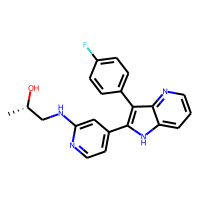
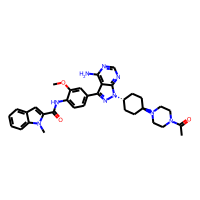
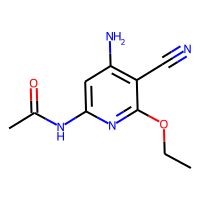
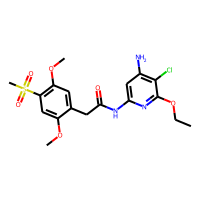
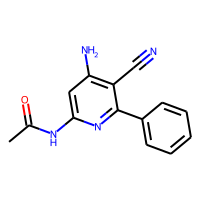
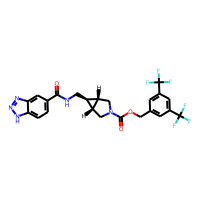
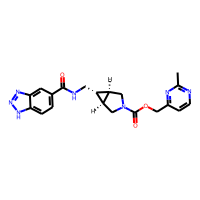
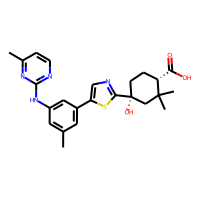
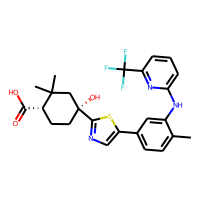
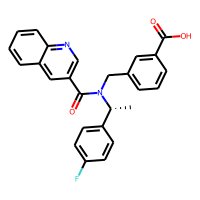

In [76]:
PandasTools.AddMoleculeColumnToFrame(df_activity_pains, smilesCol="canonical_smiles")
df_activity_pains[col_to_choose]

In [33]:
df_activity_pains[col_to_choose].describe()

,activity_id,pchembl_value,record_id,standard_text_value,standard_upper_value,standard_value,value
count,306.0,306.0,306.0,0.0,0.0,306.0,306.0
mean,318301.0,5.0,240346.0,NaN,NaN,10000.0,10000.0
std,0.0,0.0,0.0,NaN,NaN,0.0,0.0
min,318301.0,5.0,240346.0,NaN,NaN,10000.0,10000.0
25%,318301.0,5.0,240346.0,NaN,NaN,10000.0,10000.0
50%,318301.0,5.0,240346.0,NaN,NaN,10000.0,10000.0
75%,318301.0,5.0,240346.0,NaN,NaN,10000.0,10000.0
max,318301.0,5.0,240346.0,NaN,NaN,10000.0,10000.0


<a name='rgd'></a>
## R group decomposition/SAR table
Example taken from https://rdkit.blogspot.com/2019/11/constructing-sar-tables-in-jupyter.html

In [9]:
def groups_to_df(groups,mols,include_core=False,redraw_sidechains=False):
    """ converts the results of an r-group decomposition into a humanly useful
    DataFrame
    
    """
    cols = ['Mol']+list(groups.keys())
    if redraw_sidechains:
        for k,vl in groups.items():
            if k=='Core':
                continue
            for i,v in enumerate(vl):
                vl[i] = Chem.RemoveHs(v)
                rdDepictor.Compute2DCoords(vl[i])

    
    if not include_core:
        cols.remove('Core')
        del groups['Core']
    groups['Mol'] = mols
    frame = pd.DataFrame(groups,columns=cols)
    PandasTools.ChangeMoleculeRendering(frame)
    return frame

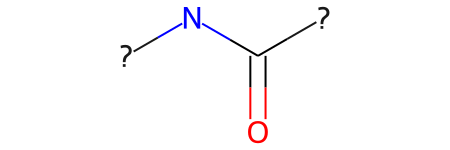

In [47]:
## look at the scoffold
doc_scaffold

0


RDKit DEBUG: [08:45:35] No core matches
RDKit DEBUG: [08:45:35] No core matches


,Mol,R1,R2,R3
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,

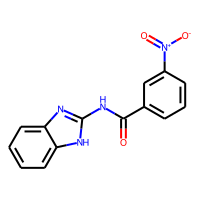
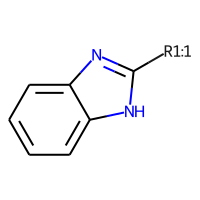
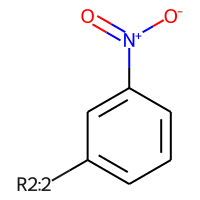
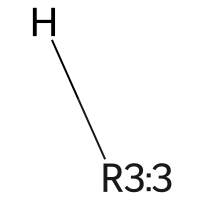
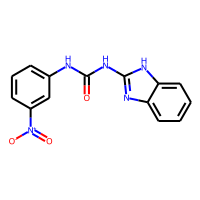
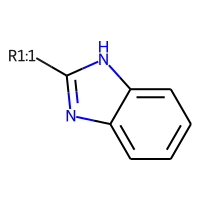
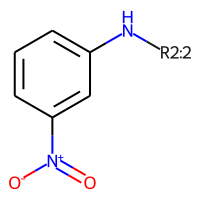
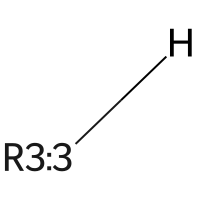
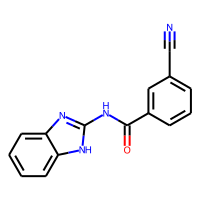
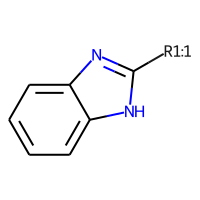
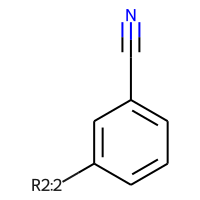
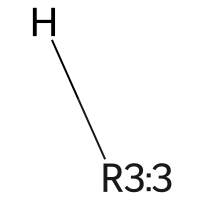
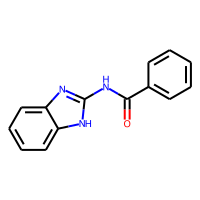
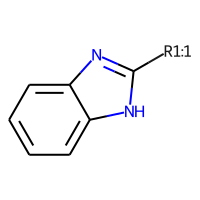
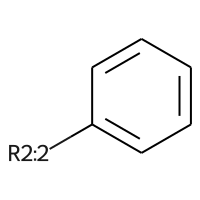
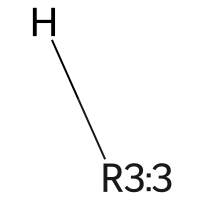
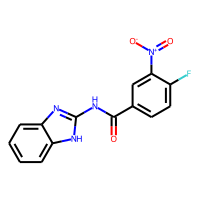
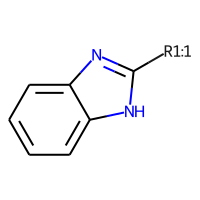
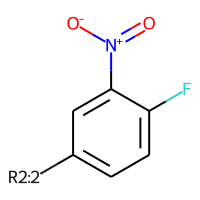
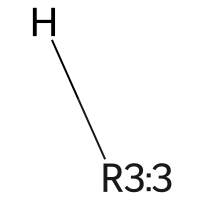

In [77]:
from rdkit.Chem import rdDepictor
# we need to provide a scaffold to use for the r-group decomposition:
doc_scaffold = Chem.MolFromSmarts('[$([#1,*])]-[#7]-[#6](-[$([#1,*])])=O')
#doc_scaffold = Chem.MolFromSmarts('[*:1]c1nc([*:2])on1')
                                   #'[*:1]-c1noc(-[*:2])n1'

# filter the data to just include the rows from a given chembl document id:
doc_id = 'CHEMBL1147720'

docdf = df_activity_pains[df_activity_pains.document_chembl_id == doc_id]

# align all the molecules to the scaffold:
rdDepictor.Compute2DCoords(doc_scaffold)
doc_scaffold
for m in docdf.ROMol:
    rdDepictor.GenerateDepictionMatching2DStructure(m,doc_scaffold, acceptFailure=True, allowRGroups=False)

# do an r-group decomposition:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([doc_scaffold],docdf.ROMol,asSmiles=False,asRows=False) 

# and look at the results:
ms = [y for x,y in enumerate(docdf.ROMol) if x not in unmatched]
res = groups_to_df(groups,ms,include_core=False)
res.head()

In [91]:
from collections import Counter
from IPython.display import HTML
import base64
import numpy as np
def mol_to_img(m):
    dm = Draw.PrepareMolForDrawing(m)
    d2d = Draw.MolDraw2DCairo(250,200)
    dopts = d2d.drawOptions()
    dopts.dummiesAreAttachments=True
    d2d.DrawMolecule(dm)
    d2d.FinishDrawing()
    png_data = d2d.GetDrawingText() 
    png_data = base64.encodebytes(png_data)
    html ='<img src="data:image/png;base64,%s">'%png_data.decode()
    return html

def run_groups(groups,unmatched,mols,values,r1_label='R1',r2_label='R2',threshold=1):
    # generate SAR matrix
    
    # generate SMILES for each of the R-groups and map those 
    # to the R-group's molecule objects:
    r1_smiles = [Chem.MolToSmiles(x) for x in groups[r1_label]]
    r2_smiles = [Chem.MolToSmiles(x) for x in groups[r2_label]]
    r1_lookup = dict(zip(r1_smiles,groups[r1_label]))
    r2_lookup = dict(zip(r2_smiles,groups[r2_label]))
    
    # all_r1s and all_r2s map R indices to the corresponding SMILES:
    all_r1s = dict([(y,x) for x,y in enumerate(r1_lookup.keys())])
    all_r2s = dict([(y,x) for x,y in enumerate(r2_lookup.keys())])
    
    # labelled_mols will contain 3-tuples:
    #   (molecule_index,R1_index,R2_index)
    labelled_mols = []
    residx = 0
    for i,m in enumerate(mols):
        if i in unmatched:
            continue
        r1_idx = all_r1s[r1_smiles[residx]]
        r2_idx = all_r2s[r2_smiles[residx]]
        residx += 1
        labelled_mols.append((i,r1_idx,r2_idx))
        
    # We only keep r groups that appear at least `threshold times in the full list:
    c1 = Counter()
    c2 = Counter()
    for idx,i,j in labelled_mols:
        c1[i] += 1
        c2[j] += 1
    freq1 = [x for x,y in c1.items() if y>=threshold]
    freq2 = [x for x,y in c2.items() if y>=threshold]
    reverse_r1s = dict([(y,x) for x,y in all_r1s.items()])
    reverse_r2s = dict([(y,x) for x,y in all_r2s.items()])
    freq_r1s = [reverse_r1s[i] for i in freq1]
    freq_r2s = [reverse_r2s[i] for i in freq2]
    n_r1 = len(freq1)
    n_r2 = len(freq2)
    
    # now construct a matrix 
    matrix = [None]*(n_r1*n_r2)
    matrix = np.reshape(matrix,(n_r1,n_r2))

    for idx,i,j in labelled_mols:
        if i not in freq1 or j not in freq2:
            continue
        r1idx = freq1.index(i)
        r2idx = freq2.index(j)
        matrix[r1idx,r2idx] = idx
    
    #matrix[0,0] = doc_scaffold # set first cell of matrix with scaffold    
    
    # now create the html from that
    html = "<table>"
    ths = "".join("<th>%s</th>"%mol_to_img(r2_lookup[x]) for x in freq_r2s)
    html += f"<tr><td></td>{ths}</tr>"
    for i1,x in enumerate(freq_r1s):
        img = mol_to_img(r1_lookup[x])
        row = f"<tr><td>{img}</td>"
        for i2,y in enumerate(freq_r2s):
            if matrix[i1,i2] is not None:
                elem = matrix[i1,i2]
                elem = values.iloc[elem]
            else:
                elem = ''
            row += f'<td>{elem}</td>'    
        row += "</tr>"
        html += row
    html += "</table>"
    return html

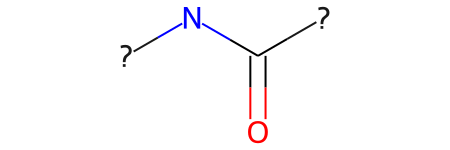

In [93]:
doc_scaffold # scaffold

In [94]:
html = run_groups(groups,unmatched,docdf.ROMol,docdf.pchembl_value)
HTML(html)

In [96]:
url_table = "http://10.0.0.146:8080/jwsdb/rest-v1/db/additional/tables"
table_name = requests.get(url_table, headers = headers)
jms_table_name = str(table_name.json())

In [97]:
jms_table_name

"[{'tableName': 'chembl_29', 'moleculeType': 'sample'}, {'tableName': 'table_2', 'moleculeType': 'sample'}, {'tableName': 'Table_1', 'moleculeType': 'sample'}]"